# Compare two approaches on computing the log determinant of the matrix $MM_{\infty}^{-1}$

In [1]:
import bempp.api
from bempp.api.assembly.blocked_operator import BlockedOperator
import math
import numpy as np
import scipy 
import cmath
from numba import objmode
from numpy.linalg import slogdet
import matplotlib.pyplot as plt
import krypy

In [2]:
h = 0.2

point = 0.5

sphere1 = bempp.api.shapes.sphere(h=h, origin=((point/2) + 1, 0, 0))
sphere2 = bempp.api.shapes.sphere(h=h, origin=(-((point/2) + 1), 0, 0))

space_sphere1 = bempp.api.function_space(sphere1, "P", 1)
space_sphere2 = bempp.api.function_space(sphere2, "P", 1)

wavenumber = 0.8*1j

slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere1, space_sphere1, wavenumber)
slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere1, space_sphere1, wavenumber)
slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere2 , space_sphere2 , wavenumber)
slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere2 , space_sphere2 , wavenumber)

mat11 = slp11.weak_form().A
mat12 = slp12.weak_form().A
mat21 = slp21.weak_form().A
mat22 = slp22.weak_form().A
mat12_zero = np.zeros((mat11.shape[0],mat22.shape[1]))
mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

mat = np.block([[mat11,mat12],[mat21,mat22]])                       # matrix M
mat2 = np.block([[mat11,mat12_zero],[mat21_zero,mat22]])            # matrix M_{infty}

n = mat.shape[0]
Id = np.eye(n)
inv_mat2 = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat2), Id)  # inversion of the matrix M_{\infty} computed through the LU decomposition

combined = inv_mat2.dot(mat)

print(np.log(np.linalg.det(combined)))

-0.11725914620404751


## Method 1

We would like to use <code>scipy.linalg.lu_solve(scipy.linalg.lu_factor(M_ii), Identity_matrix)</code>,  for i = 1 or 2 to find the inverse of $M_{\infty}$.

In [3]:
mat11_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat11), np.eye(mat11.shape[0]))
mat22_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat22), np.eye(mat22.shape[0]))

inv_free_mat2 = np.block([[mat11_inv,  mat12_zero],
                          [mat21_zero, mat22_inv]])  

combined_inverse_free = inv_free_mat2.dot(mat)

evals_inv_free, evect_inv_free = np.linalg.eig(combined_inverse_free)

In [4]:
m = 50 # dimension of the Krylov subspace 

X_combined, H_combined = krypy.utils.arnoldi(combined_inverse_free, (np.ones(n)/np.linalg.norm(np.ones(n))).reshape((n,1)), maxiter = m,  ortho='dmgs')

In [5]:
evals_H, evect_H = np.linalg.eig(H_combined[0:m, :])  

/home/xiaoshu/.conda/envs/opencl/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


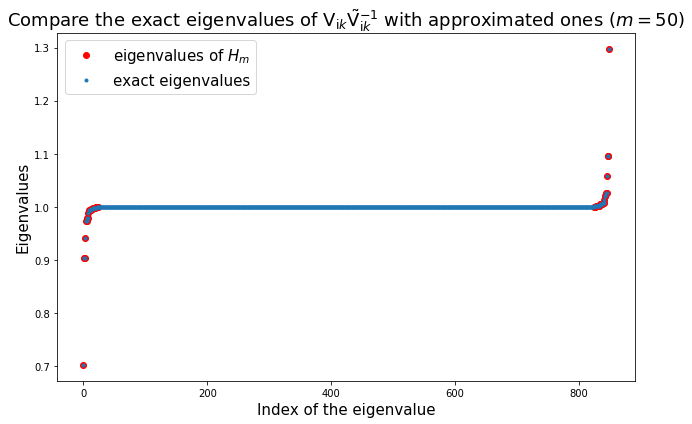

In [8]:
plt.figure(figsize = [10,6])
plt.plot(range(np.int(len(evals_H)/2)), sorted(evals_H)[0:np.int(m/2)], 'ro' , label = 'eigenvalues of $H_{m}$')
plt.plot(range(n - np.int(len(evals_H)/2), n), sorted(evals_H)[-np.int(m/2):], 'ro')

plt.plot(range(len(evals_inv_free)), sorted(evals_inv_free), '.', label = 'exact eigenvalues')
plt.xlabel('Index of the eigenvalue', fontsize = 15)
plt.ylabel('Eigenvalues', fontsize = 15)
plt.legend(fontsize = 15)
plt.title('Compare the exact eigenvalues of $\mathsf{V}_{\mathrm{i}k}\~{\mathsf{V}}_{\mathrm{i}k}^{-1}$ with approximated ones $(m = 50)$', fontsize = 18)
plt.tight_layout()

In [6]:
smallest_error_Hess = []
for i in range(np.int(m/2)):
    smallest_error_Hess.append(abs(sorted(evals_H)[i] - sorted(evals_inv_free)[i])/sorted(evals_inv_free)[i])
    
largest_error_Hess = []
for i in range(np.int(m/2)):
    largest_error_Hess.append(abs((sorted(evals_H)[-np.int(m/2):])[i]- (sorted(evals_inv_free)[-np.int(m/2):])[i])/(sorted(evals_inv_free)[-np.int(m/2):])[i])


## Method 2

We can solve the generalized eigenvalue problem $Mx = \lambda M_{\infty}x$ via a block inverse-free Krylov subspace method. This method allows us to find several smallest (or largest) eigenvalues simultaneously. 

This method is fully described in Algorithm 3 of this paper: https://www.sciencedirect.com/science/article/pii/S0377042709001812 

The procedure is as follows:

Input: Symmetric matrix $A$, s.p.d matrix $B$ and an matrix $X^{(1)} \in\mathbb{R}^{n\times p}$ with $X^{(1)*}BX = I_{p}$ and $m\geq 1$
1. $\Theta^{(1)} = \text{diag}(X^{(1)*}AX^{(1)})$

2. for $k = 1, 2, \dots$ do

3. ----for $i = 1, 2, \dots, p$ do
          
          
4. --------construct a basis $\hat{Z_{i}}$ of $K_{m}(A - \theta_{i}^{(k)}B, x_{i}^{(k)})$
5. ----end for
6. ----Orthonormalize $(\hat{Z_{1}} \cdots \hat{Z_{p}})$ to obtain $Z$
7. ----Form projection $A_{m} = Z^{*}AZ$, $B_{m} = Z^{*}BZ$
8. ----Compute $p$ smallest eigenpairs $(\theta_{i}, u_{i})$, $1\leq i \leq p$ of $(A_{m}, B_{m})$
9. ----$\Theta^{(k+1)} = \text{diag}(\theta_{1}, \dots, \theta_{p})$; $X^{(k+1)} = ZU$, $U = (u_{1} \cdots u_{p})$
10. end for

### Compute $p$ smallest eigenvalues of the matrix pencil ($M, M_{\infty}$)

In [7]:
p = 25  # the number of the smallest eigenvalues that we want to approximate
m = 50 # dimension of the Krylov subspace 

X_smallest, H = krypy.utils.arnoldi(mat2, np.ones(n).reshape((n,1)), maxiter = p-1, ip_B = mat2,  ortho='dmgs') 
# X_smallest = X is an M_{\infty}-orthonormal matrix, which means X.T M_{\infty}X = Ip, where Ip is an identity matrix with dimension p 
# and X is the initial guess of the p eigenvectors

theta_smallest = np.diag(X_smallest.T @ mat @ X_smallest) # initial guess of p eigenvalues 

for k in range(50): 

    Z_hat = np.zeros((n, p * (m+1)))
    for i in range(p):
        Z_hat[:,i*(m+1):(i+1)*(m+1)] = krypy.utils.arnoldi((mat - theta_smallest[i]*mat2), X_smallest[:,i].reshape((n,1)), maxiter = m,  ortho='dmgs')[0] 
        # for each eigenvalue, we compute its Krylov subspace and store it in Z_hat. Afterwards, we orthogonalize it and we obtain Z.
        
    Z = scipy.linalg.orth(Z_hat)     
    
    
    # project M and M_{\infty} on Z and compute the eigenvalue and eigenvectors of the pencil (A_{m}, B_{m})
    A_m = Z.T @ mat @ Z
    B_m = Z.T @ mat2 @ Z
    evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
    
    theta_smallest = sorted(evalue)[0:p] # update the eigenvalues =========================

    U = np.zeros((A_m.shape[0], p))
    for i in range(p):
        U[:,i] = evect[(list(evalue).index(sorted(evalue)[i]))]

    X_smallest = Z @ U  # update the eigenvectors =======================================

### Compute $p$ largest eigenvalues of the matrix pencil $(M, M_{\infty})$

The most trivial way to compute the $p$ largest eigenvalues is to use the same code in the last cell but only change the matrix $M$ to $-M$. Then we can find the 
$p$ smallest eigenvalues of $(-M, M_{\infty})$ and by adding the negative sign in front of these eigenvalues, we can obtain $p$ largest eigenvalues of $(M, M_{\infty})$

In [8]:
p = 25  # the number of the largest eigenvalues that we want to approximate
m = 50 # dimension of the Krylov subspace 

X_largest, H = krypy.utils.arnoldi(mat2, np.ones(n).reshape((n,1)), maxiter = p-1, ip_B = mat2,  ortho='dmgs') 

theta_largest = np.diag(X_largest.T @ mat @ X_largest) # initial guess of p eigenvalues 

for k in range(50): 

    Z_hat = np.zeros((n, p * (m+1)))
    for i in range(p):
        Z_hat[:,i*(m+1):(i+1)*(m+1)] = krypy.utils.arnoldi((-mat - theta_largest[i]*mat2), X_largest[:,i].reshape((n,1)), maxiter = m,  ortho='dmgs')[0]
        
    Z = scipy.linalg.orth(Z_hat)     
    
    
    # project M and M_{\infty} on Z and compute the eigenvalue and eigenvectors of the pencil (A_{m}, B_{m})
    A_m = Z.T @ -mat @ Z
    B_m = Z.T @ mat2 @ Z
    evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
    
    theta_largest = sorted(evalue)[0:p] # update the eigenvalues ======================

    U = np.zeros((A_m.shape[0], p))
    for i in range(p):
        U[:,i] = evect[(list(evalue).index(sorted(evalue)[i]))]

    X_largest = Z @ U  # update the eigenvectors ======================================

/home/xiaoshu/.conda/envs/opencl/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


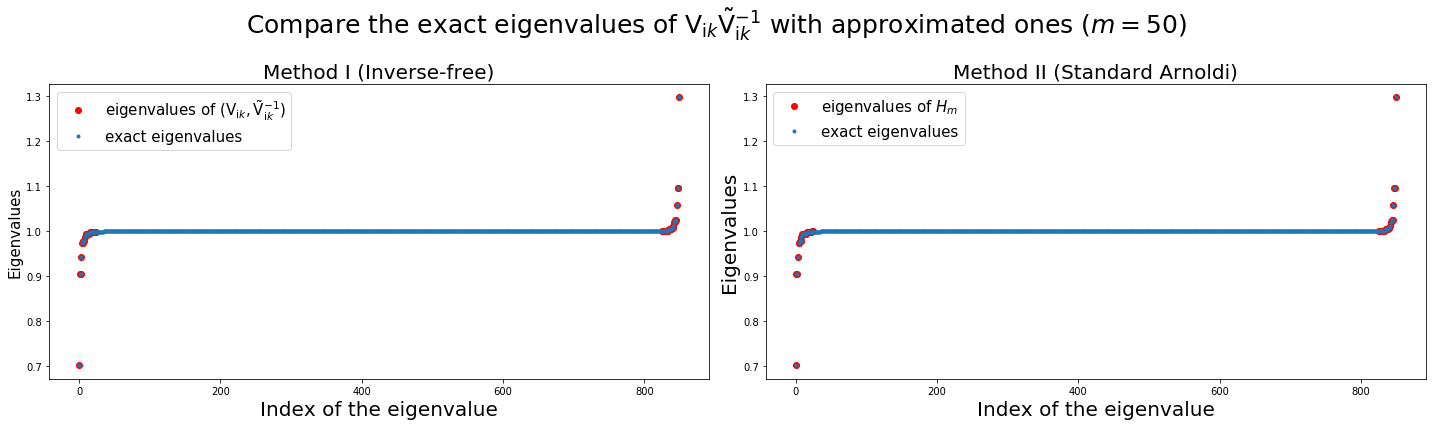

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
ax1.plot(range(p), theta_smallest, 'ro', label = 'eigenvalues of $(\mathsf{V}_{\mathrm{i}k}, \~{\mathsf{V}}_{\mathrm{i}k}^{-1})$')
ax1.plot(range(n - p, n), sorted(-np.array(theta_largest)),  'ro')
ax1.plot(range(len(evals_inv_free)), sorted(evals_inv_free), '.', label = 'exact eigenvalues')
ax1.legend(fontsize = 15)
ax1.set_xlabel('Index of the eigenvalue', fontsize = 20)
ax1.set_ylabel('Eigenvalues', fontsize = 15)
ax1.set_title('Method I (Inverse-free)', fontsize = 20)

ax2.plot(range(np.int(len(evals_H)/2)), sorted(evals_H)[0:np.int(m/2)], 'ro' , label = 'eigenvalues of $H_{m}$')
ax2.plot(range(n - np.int(len(evals_H)/2), n), sorted(evals_H)[-np.int(m/2):], 'ro')

ax2.plot(range(len(evals_inv_free)), sorted(evals_inv_free), '.', label = 'exact eigenvalues')
ax2.set_xlabel('Index of the eigenvalue', fontsize = 20)
ax2.set_ylabel('Eigenvalues', fontsize = 20)
ax2.legend(fontsize = 15)
ax2.set_title('Method II (Standard Arnoldi)', fontsize = 20)
fig.tight_layout()
fig.suptitle('Compare the exact eigenvalues of $\mathsf{V}_{\mathrm{i}k}\~{\mathsf{V}}_{\mathrm{i}k}^{-1}$ with approximated ones $(m = 50)$', fontsize = 25)
fig.subplots_adjust(top=0.8)
fig.savefig('Method_GEP_Hess_m_50.pdf')

/home/xiaoshu/.conda/envs/opencl/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


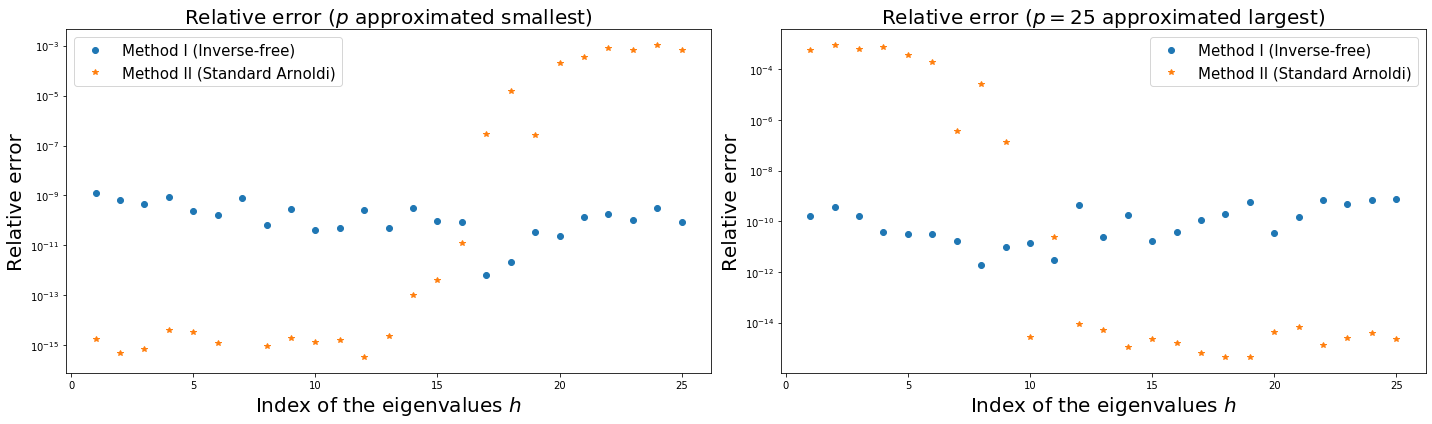

In [31]:
smallest_error = []
for i in range(len(theta_smallest)):
    smallest_error.append(abs(theta_smallest[i] - sorted(evals_inv_free)[i])/sorted(evals_inv_free)[i])
    
largest_error = []
for i in range(len(theta_largest)):
    largest_error.append(abs(sorted(-np.array(theta_largest))[i]- (sorted(evals_inv_free)[-p:])[i])/(sorted(evals_inv_free)[-p:])[i])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
ax1.semilogy(range(1, p+1), smallest_error ,'o')
ax1.semilogy(range(1, np.int(m/2)+1), smallest_error_Hess ,'*')
ax1.legend(['Method I (Inverse-free)', 'Method II (Standard Arnoldi)'], fontsize = 15)
ax1.set_xlabel('Index of the eigenvalues $h$', fontsize = 20)
ax1.set_ylabel('Relative error', fontsize = 20)
ax1.set_title('Relative error ($p$ approximated smallest)', fontsize = 20)

ax2.semilogy(range(1, p+1), largest_error ,'o')
ax2.semilogy(range(1, np.int(m/2)+1), largest_error_Hess ,'*')
ax2.legend(['Method I (Inverse-free)', 'Method II (Standard Arnoldi)'], fontsize = 15)
ax2.set_xlabel('Index of the eigenvalues $h$', fontsize = 20)
ax2.set_ylabel('Relative error', fontsize = 20)
ax2.set_title('Relative error ($p = 25$ approximated largest)', fontsize = 20)
fig.tight_layout()
fig.savefig('rel_err_GEP_Hess_m_50.pdf')

### Compare two methods in the case when the dimension of the Krylov subspace is $m = 50$ 

To more intuitively see which method is better, we would like to fix the dimension of the Krylov subspace as 50 and increase the number of the approximated eigenvalues from 2 to 50 and then plot the relative error in each case. The procedure is as follows.

If the eigenvalues obtained from the Method1 are 
$$\Lambda_{1} = \{\lambda_{0}^{(1)}, \lambda_{1}^{(1)}, \dots, \lambda_{m-1}^{(1)}\}$$ and the eigenvalues obtained from the Method2 are
$$\Lambda_{2}^{\text{smallest}} = \{\lambda_{0}^{(s)}, \lambda_{1}^{(s)}, \dots, \lambda_{p-1}^{(s)}\},$$
$$\Lambda_{2}^{\text{largest}} = \{\lambda_{0}^{(l)}, \lambda_{1}^{(l)}, \dots, \lambda_{p-1}^{(l)}\}.$$ (These sets are all sorted.)

Then we would like to compute the relative error between the exact log determinant value and the approximated logdet obtained from these two methods.

When the number of the approximated eigenvalue is 2: 

The relative error for the Method1 is computed by:

$$\left[\text{exact_logdet} - \left(\text{np.log}(\lambda_{0}^{(1)}) + \text{np.log}(\lambda_{m-1}^{(1)})\right)\right]/\text{exact_logdet}$$ and 

the relative error for the Method2 is computed by:

$$\left[\text{exact_logdet} - \left(\text{np.log}(\lambda_{0}^{(s}) + \text{np.log}(\lambda_{p-1}^{(l)})\right)\right]/\text{exact_logdet}.$$

When the number of the approximated eigenvalue is 4: 

The relative error for the Method1 is computed by:

$$\left[\text{exact_logdet} - \left(\text{np.log}(\lambda_{0}^{(1)}) + \text{np.log}(\lambda_{1}^{(1)}) +  \text{np.log}(\lambda_{m-2}^{(1)}) + \text{np.log}(\lambda_{m-1}^{(1)})\right)\right]/\text{exact_logdet}$$ and 

the relative error for the Method2 is computed by:

$$\left[\text{exact_logdet} - \left(\text{np.log}(\lambda_{0}^{(s}) + \text{np.log}(\lambda_{1}^{(s}) + \text{np.log}(\lambda_{p-2}^{(l)}) + \text{np.log}(\lambda_{p-1}^{(l)})\right)\right]/\text{exact_logdet}$$
and so on. 

In [20]:
exact_logdet = np.log(np.linalg.det(combined_inverse_free))
print(exact_logdet)

-0.11725914620403652


In [21]:
error_list1 = []
for i in range(1, np.int(m/2)+1):
    method1_logdet = 0
    for j in range(i):
        method1_logdet += np.log(sorted(evals_H)[j])
        method1_logdet += np.log(sorted(evals_H)[-j-1])
    error_list1.append(abs((method1_logdet - exact_logdet)/exact_logdet))

In [22]:
error_list2 = []
for i in range(1, p+1):
    method2_logdet = 0
    for j in range(i):
        method2_logdet += np.log(theta_smallest[j])
        method2_logdet += np.log(sorted(-np.array(theta_largest))[-j-1])
    error_list2.append(abs((method2_logdet - exact_logdet)/exact_logdet))

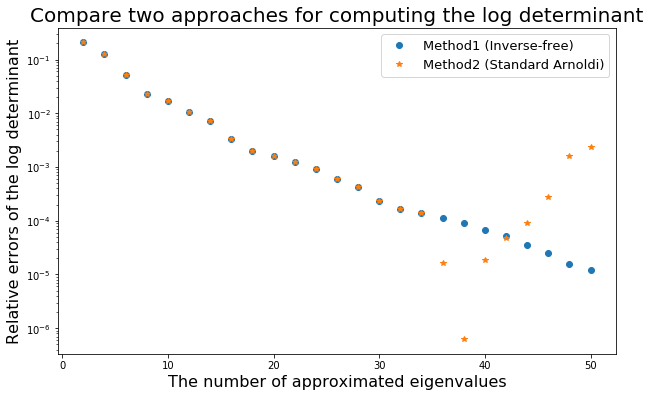

In [32]:
x_axis = [2*i for i in range(1,p+1)]
plt.figure(figsize = [10,6])
plt.semilogy(x_axis, error_list2, 'o')
plt.semilogy(x_axis, error_list1, '*')
plt.xlabel('The number of approximated eigenvalues', fontsize = 16)
plt.ylabel('Relative errors of the log determinant', fontsize = 16)
plt.legend(['Method1 (Inverse-free)', 'Method2 (Standard Arnoldi)'], fontsize = 13)
plt.title('Compare two approaches for computing the log determinant', fontsize = 20)
plt.savefig('Compare two approaches.pdf')